# Assessing the Performance of Machine Learning Algorithms for Soil Classification Using Cone Penetration Test Data

## Libraries 

In [1]:
import pandas as pd # data processing
import math
from sklearn.model_selection import train_test_split # cross validation
from sklearn.preprocessing import StandardScaler # scaling
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score # metric evaluation

## Data Preprocessing

### Read data

In [2]:
soil_data = pd.read_pickle("data_input/soil_behaviour_type_cpt.pkl")
soil_data.head()

,depth,qc,fs,Rf,lc,soil_type
0,0.015,3930.0,5.4,0.001374,1.242170,gravelly sands to dense sand
1,0.020,5060.0,5.4,0.001067,1.309667,gravelly sands to dense sand
2,0.025,5350.0,9.8,0.001832,1.331114,sands
3,0.030,5620.0,9.8,0.001744,1.350951,sands
4,0.035,5950.0,11.7,0.001966,1.376021,sands


### Data Cleansing

In [3]:
soil_data.drop(columns=['Rf', 'lc'], inplace=True)

In [4]:
soil_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221139 entries, 0 to 229982
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   depth      221139 non-null  float64 
 1   qc         221139 non-null  float64 
 2   fs         221139 non-null  float64 
 3   soil_type  221139 non-null  category
dtypes: category(1), float64(3)
memory usage: 7.0 MB


### Cross Validation

In [5]:
# subset kolom numerik
cols = soil_data.select_dtypes('number').columns

X_train, X_test, y_train, y_test = train_test_split(soil_data[cols],
                                                   soil_data['soil_type'],
                                                   test_size=0.20, 
                                                   stratify=soil_data['soil_type'],
                                                   random_state=13)


In [6]:
pd.crosstab(index = y_train, 
            columns = 'prop', 
            normalize = True)

col_0,prop
soil_type,
clays,0.000356
gravelly sands to dense sand,0.436982
organic soil,0.000232
sand mixtures,0.002425
sands,0.559603
silt mixtures,0.000401


In [7]:
pd.crosstab(index = y_test, 
            columns = 'prop', 
            normalize = True)

col_0,prop
soil_type,
clays,0.000362
gravelly sands to dense sand,0.436986
organic soil,0.000226
sand mixtures,0.002419
sands,0.559600
silt mixtures,0.000407


### Scaling the data

In [8]:
# Scale the features using StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## K-Nearest Neighbor

### Find appropriate K

In [9]:
# find appropriape k value
math.sqrt(X_train.shape[0])

420.60789341142896

To avoid a tie when majority voting, round the value up because the target class has an even number (six soil type).

### Fitting the model 

In [10]:
# fitting model
from sklearn.neighbors import KNeighborsClassifier

# code for build knn model
knn_geotech = KNeighborsClassifier(n_neighbors=421)
knn_geotech.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=421)

### Prediction

In [11]:
soil_prediction = knn_geotech.predict(X_test)
soil_prediction

array(['gravelly sands to dense sand', 'sands',
       'gravelly sands to dense sand', ...,
       'gravelly sands to dense sand', 'sands',
       'gravelly sands to dense sand'], dtype=object)

### Model Evaluation

In [12]:
# confussion matrix
pd.crosstab(soil_prediction, y_test)

soil_type,clays,gravelly sands to dense sand,organic soil,sand mixtures,sands,silt mixtures
row_0,,,,,,
gravelly sands to dense sand,0,18942,0,0,599,0
sand mixtures,15,0,10,44,0,16
sands,1,385,0,63,24151,2


> here are some labels in y_true, which dont appear in y_pred

In [13]:
print('Accuracy score: ', accuracy_score(y_test, soil_prediction))
print('Precision score: ', precision_score(y_test, soil_prediction, average='weighted', zero_division=0))
print('Recall score: ', recall_score(y_test, soil_prediction, average='weighted'))
print('F1 score: ', f1_score(y_test, soil_prediction, average='weighted'))

Accuracy score:  0.9753323686352536
Precision score:  0.9741845656837902
Recall score:  0.9753323686352536
F1 score:  0.9747258777956656


## Decision Tree 

### Fitting the model 

In [14]:
# model initialization
decision_tree_geotech = DecisionTreeClassifier(random_state=10)

# fit model
decision_tree_geotech.fit(X_train, y_train)

DecisionTreeClassifier(random_state=10)

### Visualization

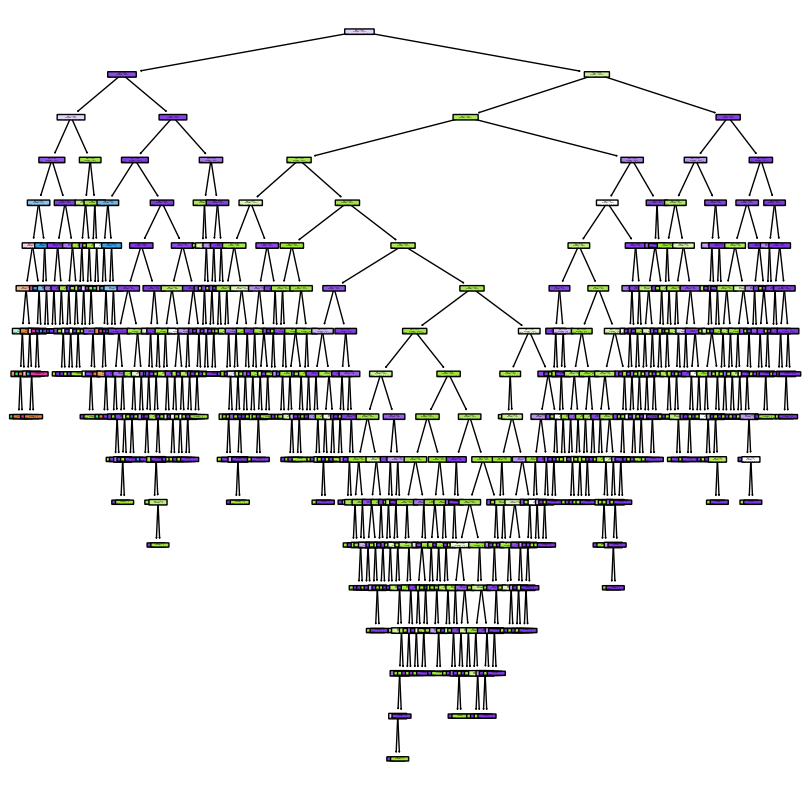

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# visualization
plt.figure(figsize=(10,10))
plot_tree(decision_tree_geotech, 
          feature_names=soil_data.select_dtypes('number').columns.to_list(), 
          filled=True, 
          rounded=True);

In [16]:
from sklearn.tree import export_text
tree_text = export_text(decision_tree_geotech, 
                        feature_names=soil_data.select_dtypes('number').columns.to_list())
print(tree_text)

|--- qc <= -0.44
|   |--- fs <= -1.36
|   |   |--- qc <= -0.68
|   |   |   |--- qc <= -1.66
|   |   |   |   |--- qc <= -1.86
|   |   |   |   |   |--- qc <= -1.93
|   |   |   |   |   |   |--- qc <= -1.99
|   |   |   |   |   |   |   |--- fs <= -1.69
|   |   |   |   |   |   |   |   |--- qc <= -2.02
|   |   |   |   |   |   |   |   |   |--- class: organic soil
|   |   |   |   |   |   |   |   |--- qc >  -2.02
|   |   |   |   |   |   |   |   |   |--- class: clays
|   |   |   |   |   |   |   |--- fs >  -1.69
|   |   |   |   |   |   |   |   |--- class: organic soil
|   |   |   |   |   |   |--- qc >  -1.99
|   |   |   |   |   |   |   |--- qc <= -1.94
|   |   |   |   |   |   |   |   |--- class: clays
|   |   |   |   |   |   |   |--- qc >  -1.94
|   |   |   |   |   |   |   |   |--- depth <= -1.77
|   |   |   |   |   |   |   |   |   |--- class: silt mixtures
|   |   |   |   |   |   |   |   |--- depth >  -1.77
|   |   |   |   |   |   |   |   |   |--- class: clays
|   |   |   |   |   |--- qc >  -1.93

### Prediction

In [17]:
soil_prediction_dt = decision_tree_geotech.predict(X_test)
soil_prediction_dt

array(['gravelly sands to dense sand', 'sands',
       'gravelly sands to dense sand', ...,
       'gravelly sands to dense sand', 'sands',
       'gravelly sands to dense sand'], dtype=object)

### Model Evaluation

In [18]:
# confussion matrix
pd.crosstab(soil_prediction_dt, y_test)

soil_type,clays,gravelly sands to dense sand,organic soil,sand mixtures,sands,silt mixtures
row_0,,,,,,
clays,16,0,0,0,0,0
gravelly sands to dense sand,0,19304,0,0,25,0
organic soil,0,0,10,0,0,0
sand mixtures,0,0,0,105,1,1
sands,0,23,0,2,24724,0
silt mixtures,0,0,0,0,0,17


In [19]:
print('Accuracy score: ', accuracy_score(y_test, soil_prediction_dt))
print('Precision score: ', precision_score(y_test, soil_prediction_dt, average='weighted', zero_division=0))
print('Recall score: ', recall_score(y_test, soil_prediction_dt, average='weighted'))
print('F1 score: ', f1_score(y_test, soil_prediction_dt, average='weighted'))

Accuracy score:  0.9988242742154292
Precision score:  0.9988243098635449
Recall score:  0.9988242742154292
F1 score:  0.9988239676414409


## Random Forest 

### Fitting the model 

In [20]:
# model intialize 
random_forest_geotech = RandomForestClassifier(random_state=10, 
                                   oob_score = True)

# model training
random_forest_geotech.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=10)

### Prediction

In [21]:
soil_prediction_rf = random_forest_geotech.predict(X_test)
soil_prediction_rf

array(['gravelly sands to dense sand', 'sands',
       'gravelly sands to dense sand', ...,
       'gravelly sands to dense sand', 'sands',
       'gravelly sands to dense sand'], dtype=object)

### Model Evaluation

In [22]:
# confussion matrix
pd.crosstab(soil_prediction_rf, y_test)

soil_type,clays,gravelly sands to dense sand,organic soil,sand mixtures,sands,silt mixtures
row_0,,,,,,
clays,15,0,0,0,0,0
gravelly sands to dense sand,0,19295,0,0,45,0
organic soil,0,0,10,0,0,0
sand mixtures,0,0,0,107,0,0
sands,0,32,0,0,24705,0
silt mixtures,1,0,0,0,0,18


In [23]:
print('Accuracy score: ', accuracy_score(y_test, soil_prediction_rf))
print('Precision score: ', precision_score(y_test, soil_prediction_rf, average='weighted', zero_division=0))
print('Recall score: ', recall_score(y_test, soil_prediction_rf, average='weighted'))
print('F1 score: ', f1_score(y_test, soil_prediction_rf, average='weighted'))

Accuracy score:  0.9982364113231437
Precision score:  0.9982379050116507
Recall score:  0.9982364113231437
F1 score:  0.9982364161745485


## Performance Summary 

In [24]:
print('K-Nearest Neighbor base model F1 score: ', f1_score(y_test, soil_prediction, average='weighted').round(3))
print('Decision Tree base model F1 score: ', f1_score(y_test, soil_prediction_dt, average='weighted').round(3))
print('Random Forest base model F1 score: ', f1_score(y_test, soil_prediction_rf, average='weighted').round(3))

K-Nearest Neighbor base model F1 score:  0.975
Decision Tree base model F1 score:  0.999
Random Forest base model F1 score:  0.998


All model performances produced excellent evaluations with the highest score achieved by the tree family model